# Coin Counter Final

An implementation of a live coin counter using a webcam in Python.|

In [6]:
import os.path
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure
from sklearn import cluster
import matplotlib.pylab as plt
import cv2
plt.gray();

<Figure size 432x288 with 0 Axes>

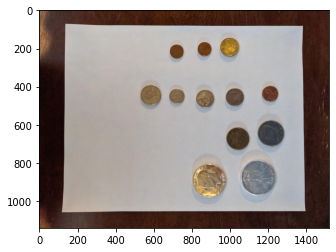

In [18]:
im = io.imread('../coins_paper.jpg')
plt.imshow(im)

In [21]:
def nonzero(x):
    """
    If given 0 then this returns an extremely tiny, but non-zero, positive value. Otherwise the
    given value is returned. The value x must be a scalar and cannot be an array.
    """
    return np.finfo(float).eps if x == 0 else x

def threshold(im):
    thres_im = ~cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    return thres_im

def largest_connected_component(thresh):
    """Connected components to get largest component in the image as a boolean image"""
    lbls = measure.label(thresh) # or cv2.connectedComponents(th, 8)
    if lbls.max() == 0: return np.zeros(thresh.shape, dtype=bool) # nothing found
    _, i = max(((lbls == i).sum(), i) for i in range(1, lbls.max()+1)) # find index of largest component
    return lbls == i

def largest_contour(contours):
    """
    Finds the largest contour (in terms of area).
    
    NOTE: This could use len(c) or cv2.arcLength(c, True) for different metrics to maximize
    instead of area.
    """
    if len(contours) == 0: return None
    _,c = max((cv2.contourArea(c), c) for c in contours)
    return c

def cos(pt0, pt1, pt2):
    """
    Calculate the cosine of the angle between the vectors from pt0 to pt1 and
    pt0 to pt2. This is done using the dot product and normalization.
    """
    v1 = (pt1 - pt0).astype(float)
    v2 = (pt2 - pt0).astype(float)
    return v1.dot(v2) / np.sqrt(nonzero((v1*v1).sum()*(v2*v2).sum()))

def dist(pt0, pt1):
    """Calculates the distance between two points."""
    d = pt0-pt1
    return np.sqrt((d*d).sum())

def is_approx_rectangular(contour, side_length_err=0.2, cosine_err=0.25):
    """
    Checks if a contour represents an approximate rectangle. It must have 4
    corners, be convex, have approximate equal side length for longer and
    shorter sides, and approximately 90 degree angles.
    
    The contour given as an Nx1x2 or Nx2 array. The side_length_err is the
    percent of maximum side length allowed as the difference between shortest
    and longest sides. The cosine_err is the values of cosine to consider around
    90 degrees.
    
    The err values may need to be tweaked for a specific applciation.
    """
    contour = contour.squeeze() # remove the length-1 dimension
    
    # Check Basics (4 corners and convex)
    if len(contour) != 4 or not cv2.isContourConvex(contour): return False
    # Check Side Lengths
    lengths = [dist(contour[i], contour[(i+1)%4]) for i in range(4)]
    lengths.sort()

    # Check shorter side lengths
    if (lengths[1] - lengths[0]) > side_length_err * lengths[3]: return False
    # Check longer side lengths
    if (lengths[3] - lengths[2]) > side_length_err * lengths[3]: return False

    # Check Angles
    # Gets the cosine of each corner by and making sure they are near 0 (since
    # the cosine of 90 degrees is 0).
    cosines = [abs(cos(contour[i], contour[(i+1)%4], contour[(i-1)%4])) for i in range(4)]
    if max(cosines) > cosine_err: return False
       
    return True

def orient_rect(contour):
    """
    Takes a contour and orients it so that 0,0 is in the top-left corner and the
    other points go clockwise around the shape. The contour must be only 4 points.
    """
    contour = contour.squeeze()
    # Find the point closest to (0,0)
    # We need to find the top-left-most coordinate
    tl_idx = (contour*contour).sum(1).argmin()
    tl = contour[tl_idx]
    # The contour is either clockwise or counter-clockwise. The point either before
    # or after the found TL point, and it will be the one with the closer y value
    br = contour[(tl_idx+2)%4]
    a,b = contour[(tl_idx+1)%4], contour[(tl_idx-1)%4]
    if abs(tl[1]-a[1]) < abs(tl[1]-b[1]):
        # Next point (a) is top-right
        return np.array([tl, a, br, b], "float32")
    else:
        # Previous point (b) is top-right
        return np.array([tl, b, br, a], "float32")


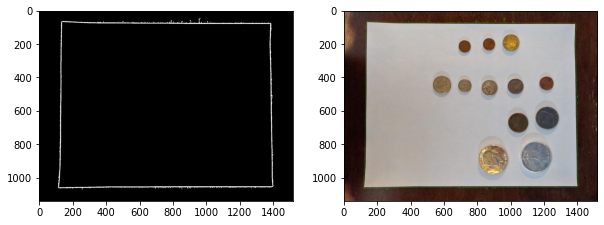

In [99]:
plt.figure(figsize=(10, 20))

gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (11,11), 1.5)

# Threshold image and get the largest component which should be the white background (expected to be a piece of paper)
thres_im = threshold(blur)
paper = largest_connected_component(thres_im)

plt.subplot(121)
plt.imshow(paper)

# Get the contours in the image and find the largest
contours,_ = cv2.findContours(paper.view('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = largest_contour(contours)
if contour is None: print("Invalid")

# Display the found contour on top of the original image
plt.subplot(122)
plt.imshow(cv2.drawContours(im.copy(), [contour], -1, (0,255,0)))

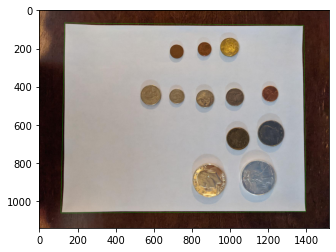

In [100]:
APPROX_PERC = 0.02 # distance to approximate contour as a percent of the perimeter

# Contour area must be >=50% of the image area (if not print "Invalid")
area = cv2.contourArea(contour)
if area < thres_im.size * 0.5: print("Invalid", area, thres_im.size*0.5)

# Approximate it by letting it move up to 2% the length of the perimeter   
epsilon = APPROX_PERC * cv2.arcLength(contour, True)
approx = cv2.approxPolyDP(contour, epsilon, True)

# Display the approximate contour
plt.imshow(cv2.drawContours(im.copy(), [approx], -1, (0,255,0)))

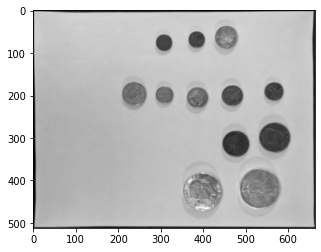

In [101]:
if not is_approx_rectangular(approx): print("Invalid")

SHAPE = (663, 512) # destination image size
dst = np.array([[0,0],[SHAPE[0]-1,0],[SHAPE[0]-1,SHAPE[1]-1],[0,SHAPE[1]-1]], "float32")

# We need to find the top-left-most coordinate
# Find the point closest to (0,0)
def orient_rect(contour):
    contour = contour.squeeze()
    tl_idx = (contour*contour).sum(1).argmin()
    tl = contour[tl_idx]
    # The contour is either clockwise or counter-clockwise. The point either before
    # or after the found TL point, and it will be the one with the closer y value
    br = contour[(tl_idx+2)%4]
    a,b = contour[(tl_idx+1)%4], contour[(tl_idx-1)%4]
    if abs(tl[1]-a[1]) < abs(tl[1]-b[1]):
        # Next point (a) is top-right
        return np.array([tl, a, br, b], "float32")
    else:
        # Previous point (b) is top-right
        return np.array([tl, b, br, a], "float32")

src = orient_rect(approx)

# Perform the actual transformation
transform = cv2.getPerspectiveTransform(src, dst)
paper = cv2.warpPerspective(blur, transform, SHAPE)

plt.imshow(paper)

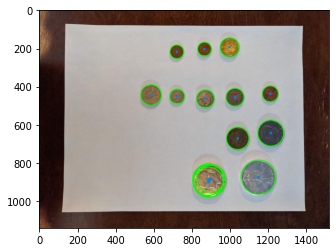

In [105]:
#thres_paper = ~cv2.adaptiveThreshold(paper, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

output = im.copy()
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.4, 10, minRadius=1)
# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

plt.imshow(output)

In [106]:
camera = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = camera.read()

    output = im.copy()
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.4, 10, minRadius=1)
    # ensure at least some circles were found
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            # draw the circle in the output image, then draw a rectangle
            # corresponding to the center of the circle
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # Display the resulting frame
    cv2.imshow('frame', output)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
camera.release()
cv2.destroyAllWindows()

In [103]:
def count_coins(currency=None):
    if currency is None:
        # Default currency is US currency
        currency = [(0.01, 19.05), (0.05, 21.21), (0.1, 17.91), (0.25, 24.26)]
    bg_area = 60322.46 # 8.5x11 in paper (215.9x279.4 mm)
    # Convert diameters into area ratios
    currency = [(val, np.pi*((diam/2)**2) / bg_area) for val, diam in currency]
    
    return 0

In [ ]:
print(f'Total value: {count_coins()}')